In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from constants import *

In [2]:
RESULTS_FOLDER = "results"
EXEC_FOLDER = os.path.join(RESULTS_FOLDER, "execution")
EXEC_FOLLOWUP_FOLDER = os.path.join(RESULTS_FOLDER, "execution_followup")

In [3]:
metrics = pd.read_csv(os.path.join(RESULTS_FOLDER, "metrics.csv"))
metrics_followup = pd.read_csv(os.path.join(RESULTS_FOLDER, "metrics_followup.csv"))
exec_metrics = pd.read_csv(os.path.join(RESULTS_FOLDER, "execution_metrics.csv"))
exec_metrics_followup = pd.read_csv(os.path.join(RESULTS_FOLDER, "execution_followup_metrics.csv"))

In [4]:
metrics = metrics[["model", "task", "from_lang", "to_lang", "valid"]]
metrics_followup = metrics_followup[
    ["model", "task", "from_lang", "to_lang", "valid"]
].rename(columns={"valid": "valid_followup"})
exec_metrics = exec_metrics[["model", "task", "from_lang", "to_lang", "run"]]
exec_metrics_followup = exec_metrics_followup[
    ["model", "task", "from_lang", "to_lang", "run"]
].rename(columns={"run": "run_followup"})

In [5]:
merged_metrics = metrics.merge(
    metrics_followup, how="left", on=["model", "task", "from_lang", "to_lang"]
)
merged_metrics["valid_followup"] = merged_metrics["valid_followup"].fillna(
    merged_metrics["valid"]
)

merged_metrics = merged_metrics.merge(
    exec_metrics, how="left", on=["model", "task", "from_lang", "to_lang"]
)
merged_metrics["run"] = merged_metrics["run"].mask(merged_metrics["valid"] == 0.0, 0.0)

merged_metrics = merged_metrics.merge(
    exec_metrics_followup, how="left", on=["model", "task", "from_lang", "to_lang"]
)
merged_metrics["run_followup"] = merged_metrics["run_followup"].fillna(
    merged_metrics["run"]
)

In [6]:
merged_metrics.head()

,model,task,from_lang,to_lang,valid,valid_followup,run,run_followup
0,deepseekcoder7b,bit_ops,py,c,0.0,1.0,0.0,1.0
1,codegeex4,str_interp,c,java,1.0,1.0,1.0,1.0
2,yicoder2b,str_interp,cpp,go,1.0,1.0,1.0,1.0
3,codeqwen,int_arith,go,cpp,1.0,1.0,1.0,1.0
4,magicoder7b,file_size,java,rs,0.0,0.0,0.0,0.0


In [7]:
def update_run(row):
    stdout_fname = os.path.join(
        EXEC_FOLDER,
        f"{row["model"]}-{row["task"]}-{row["from_lang"]}-{row["to_lang"]}_stdout.txt",
    )
    stderr_fname = os.path.join(
        EXEC_FOLDER,
        f"{row["model"]}-{row["task"]}-{row["from_lang"]}-{row["to_lang"]}_stderr.txt",
    )
    if row["run"] == 0.0:
        if os.path.exists(stdout_fname) and os.path.exists(stderr_fname):
            stderr = open(stderr_fname, "r").readline()
            if "Execution timeout" in stderr:
                row["run"] = 1.0
        elif os.path.exists(stdout_fname):
            row["run"] = 1.0
    else:
        if not os.path.exists(stdout_fname) and not os.path.exists(stderr_fname):
            row["run"] = 1.0
        elif os.path.exists(stderr_fname):
            row["run"] = 0.0
    return row


merged_metrics = merged_metrics.apply(update_run, axis=1)

In [8]:
def update_run_followup(row):
    stdout_fname = os.path.join(
        EXEC_FOLLOWUP_FOLDER,
        f"{row["model"]}-{row["task"]}-{row["from_lang"]}-{row["to_lang"]}_stdout.txt",
    )
    stderr_fname = os.path.join(
        EXEC_FOLLOWUP_FOLDER,
        f"{row["model"]}-{row["task"]}-{row["from_lang"]}-{row["to_lang"]}_stderr.txt",
    )
    if row["run_followup"] == 0.0:
        if os.path.exists(stdout_fname) and os.path.exists(stderr_fname):
            stderr = open(stderr_fname, "r").readline()
            if "Execution timeout" in stderr:
                row["run_followup"] = 1.0
        elif os.path.exists(stdout_fname):
            row["run_followup"] = 1.0
    else:
        if not os.path.exists(stdout_fname) and not os.path.exists(stderr_fname):
            row["run_followup"] = 1.0
        elif os.path.exists(stderr_fname):
            row["run_followup"] = 0.0
    return row


merged_metrics = merged_metrics.apply(update_run_followup, axis=1)

In [9]:
merged_metrics["model"] = merged_metrics["model"].apply(lambda x: MODELS[x])
merged_metrics["task"] = merged_metrics["task"].apply(lambda x: TASKS[x])
merged_metrics["from_lang"] = merged_metrics["from_lang"].apply(
    lambda x: LANGS[x.upper()]
)
merged_metrics["to_lang"] = merged_metrics["to_lang"].apply(lambda x: LANGS[x.upper()])

merged_metrics = merged_metrics.rename(
    columns={
        "valid": "CCR",
        "valid_followup": "CCR Follow-up",
        "run": "Pass@1",
        "run_followup": "Pass@1 Follow-up",
    }
)

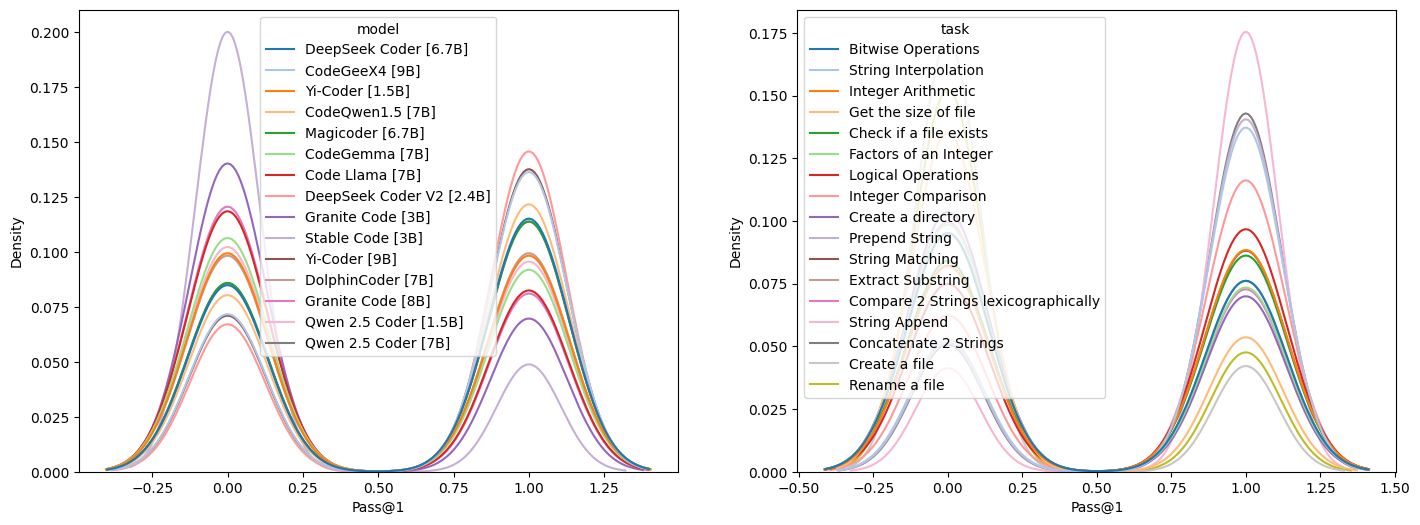

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
_ = sns.kdeplot(merged_metrics, x="Pass@1", hue="model", palette="tab20", ax=ax[0])
_ = sns.kdeplot(merged_metrics, x="Pass@1", hue="task", palette="tab20", ax=ax[1])

In [11]:
model_metrics = (
    merged_metrics.groupby("model")[
        ["CCR", "CCR Follow-up", "Pass@1", "Pass@1 Follow-up"]
    ]
    .mean()
    .reset_index()
)
model_metrics["CCR Increase"] = model_metrics["CCR Follow-up"] - model_metrics["CCR"]
model_metrics["Pass@1 Increase"] = (
    model_metrics["Pass@1 Follow-up"] - model_metrics["Pass@1"]
)
model_metrics = model_metrics[
    [
        "model",
        "CCR",
        "CCR Follow-up",
        "CCR Increase",
        "Pass@1",
        "Pass@1 Follow-up",
        "Pass@1 Increase",
    ]
]
model_metrics.sort_values("CCR", ascending=False)

,model,CCR,CCR Follow-up,CCR Increase,Pass@1,Pass@1 Follow-up,Pass@1 Increase
4,DeepSeek Coder V2 [2.4B],0.833333,0.885154,0.051821,0.684874,0.724090,0.039216
14,Yi-Coder [9B],0.801120,0.899160,0.098039,0.659664,0.745098,0.085434
1,CodeGeeX4 [9B],0.798319,0.900560,0.102241,0.655462,0.733894,0.078431
3,CodeQwen1.5 [7B],0.726891,0.830532,0.103641,0.602241,0.686275,0.084034
9,Magicoder [6.7B],0.705882,0.824930,0.119048,0.570028,0.673669,0.103641
11,Qwen 2.5 Coder [7B],0.689076,0.866947,0.177871,0.570028,0.708683,0.138655
5,DeepSeek Coder [6.7B],0.658263,0.799720,0.141457,0.575630,0.700280,0.124650
6,DolphinCoder [7B],0.635854,0.753501,0.117647,0.502801,0.596639,0.093838
2,CodeGemma [7B],0.612045,0.694678,0.082633,0.463585,0.532213,0.068627
10,Qwen 2.5 Coder [1.5B],0.598039,0.736695,0.138655,0.483193,0.599440,0.116246


In [12]:
task_metrics = (
    merged_metrics.groupby("task")[["CCR", "CCR Follow-up", "Pass@1", "Pass@1 Follow-up"]]
    .mean()
    .reset_index()
)
task_metrics["CCR Increase"] = task_metrics["CCR Follow-up"] - task_metrics["CCR"]
task_metrics["Pass@1 Increase"] = task_metrics["Pass@1 Follow-up"] - task_metrics["Pass@1"]
task_metrics = task_metrics[
    [
        "task",
        "CCR",
        "CCR Follow-up",
        "CCR Increase",
        "Pass@1",
        "Pass@1 Follow-up",
        "Pass@1 Increase",
    ]
]
task_metrics.sort_values("CCR", ascending=False)

,task,CCR,CCR Follow-up,CCR Increase,Pass@1,Pass@1 Follow-up,Pass@1 Increase
14,String Append,0.826984,0.907937,0.080952,0.809524,0.890476,0.080952
3,Concatenate 2 Strings,0.761905,0.844444,0.082540,0.738095,0.819048,0.080952
10,Integer Comparison,0.761905,0.826984,0.065079,0.650794,0.712698,0.061905
15,String Interpolation,0.747619,0.823810,0.076190,0.722222,0.798413,0.076190
12,Prepend String,0.739683,0.836508,0.096825,0.731746,0.828571,0.096825
9,Integer Arithmetic,0.707937,0.796825,0.088889,0.519048,0.590476,0.071429
8,Get the size of file,0.636508,0.712698,0.076190,0.284127,0.307937,0.023810
13,Rename a file,0.603175,0.695238,0.092063,0.238095,0.284127,0.046032
1,Check if a file exists,0.601587,0.687302,0.085714,0.506349,0.582540,0.076190
16,String Matching,0.590476,0.674603,0.084127,0.517460,0.590476,0.073016


In [13]:
from_lang_metrics = (
    merged_metrics.groupby("from_lang")[["CCR", "CCR Follow-up", "Pass@1", "Pass@1 Follow-up"]]
    .mean()
    .reset_index()
)
from_lang_metrics["CCR Increase"] = from_lang_metrics["CCR Follow-up"] - from_lang_metrics["CCR"]
from_lang_metrics["Pass@1 Increase"] = from_lang_metrics["Pass@1 Follow-up"] - from_lang_metrics["Pass@1"]
from_lang_metrics = from_lang_metrics[
    [
        "from_lang",
        "CCR",
        "CCR Follow-up",
        "CCR Increase",
        "Pass@1",
        "Pass@1 Follow-up",
        "Pass@1 Increase",
    ]
]
from_lang_metrics.sort_values("CCR", ascending=False)

,from_lang,CCR,CCR Follow-up,CCR Increase,Pass@1,Pass@1 Follow-up,Pass@1 Increase
1,C++,0.685621,0.777124,0.091503,0.544444,0.615033,0.070588
6,Rust,0.672549,0.757516,0.084967,0.560131,0.627451,0.067320
0,C,0.671895,0.766013,0.094118,0.521569,0.605229,0.083660
2,Golang,0.658170,0.751634,0.093464,0.513725,0.587582,0.073856
3,Java,0.588889,0.694118,0.105229,0.501307,0.590850,0.089542
5,Python,0.549673,0.668627,0.118954,0.458824,0.561438,0.102614
4,JavaScript,0.541176,0.666667,0.125490,0.449020,0.554248,0.105229


In [14]:
to_lang_metrics = (
    merged_metrics.groupby("to_lang")[["CCR", "CCR Follow-up", "Pass@1", "Pass@1 Follow-up"]]
    .mean()
    .reset_index()
)
to_lang_metrics["CCR Increase"] = to_lang_metrics["CCR Follow-up"] - to_lang_metrics["CCR"]
to_lang_metrics["Pass@1 Increase"] = to_lang_metrics["Pass@1 Follow-up"] - to_lang_metrics["Pass@1"]
to_lang_metrics = to_lang_metrics[
    [
        "to_lang",
        "CCR",
        "CCR Follow-up",
        "CCR Increase",
        "Pass@1",
        "Pass@1 Follow-up",
        "Pass@1 Increase",
    ]
]
to_lang_metrics.sort_values("Pass@1 Increase", ascending=False)

,to_lang,CCR,CCR Follow-up,CCR Increase,Pass@1,Pass@1 Follow-up,Pass@1 Increase
6,Rust,0.396078,0.598039,0.201961,0.296732,0.459477,0.162745
2,Golang,0.514379,0.672549,0.158170,0.447712,0.583660,0.135948
0,C,0.475817,0.626144,0.150327,0.412418,0.537255,0.124837
1,C++,0.445098,0.535948,0.090850,0.404575,0.484967,0.080392
3,Java,0.733333,0.804575,0.071242,0.616340,0.674510,0.058170
4,JavaScript,0.912418,0.935948,0.023529,0.647059,0.664052,0.016993
5,Python,0.890850,0.908497,0.017647,0.724183,0.737908,0.013725


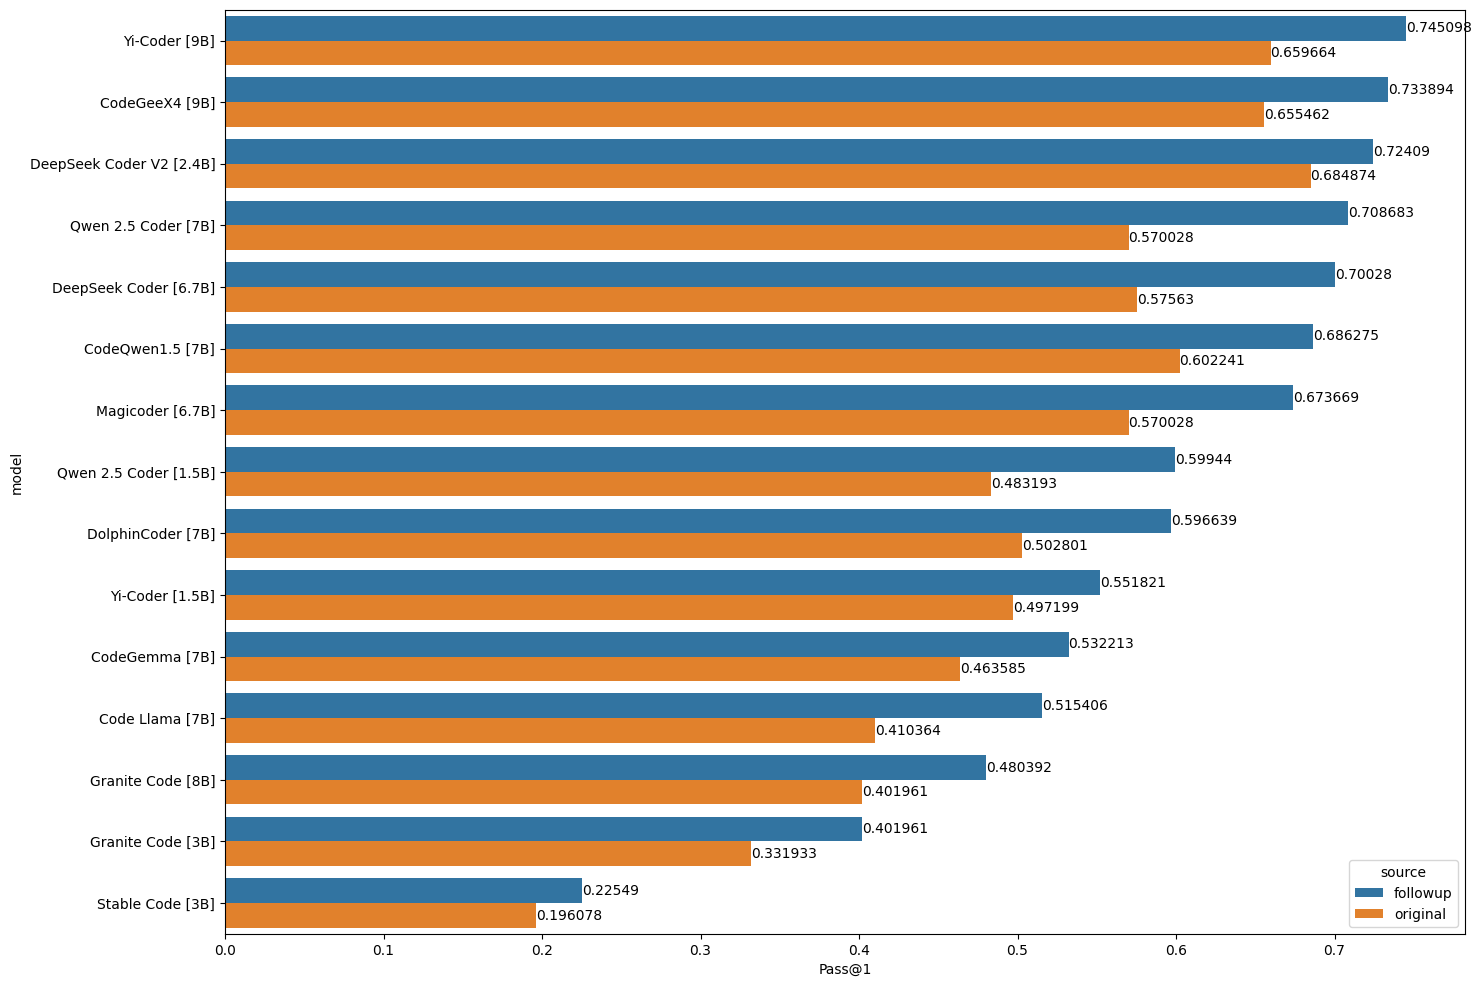

In [15]:
plot_metrics = model_metrics[["model", "Pass@1"]].copy()
plot_metrics["source"] = "original"
plot_followup_metrics = (
    model_metrics[["model", "Pass@1 Follow-up"]]
    .rename(columns={"Pass@1 Follow-up": "Pass@1"})
    .copy()
)
plot_followup_metrics["source"] = "followup"
plot_metrics = pd.concat([plot_metrics, plot_followup_metrics])
plot_metrics = plot_metrics.sort_values("Pass@1", ascending=False)
fig, ax = plt.subplots(figsize=(16, 12))
_ = sns.barplot(
    plot_metrics, y="model", x="Pass@1", hue="source", legend="brief", ax=ax
)
_ = ax.set_xlabel("Pass@1")
_ = ax.bar_label(ax.containers[0], fontsize=10)
_ = ax.bar_label(ax.containers[1], fontsize=10)

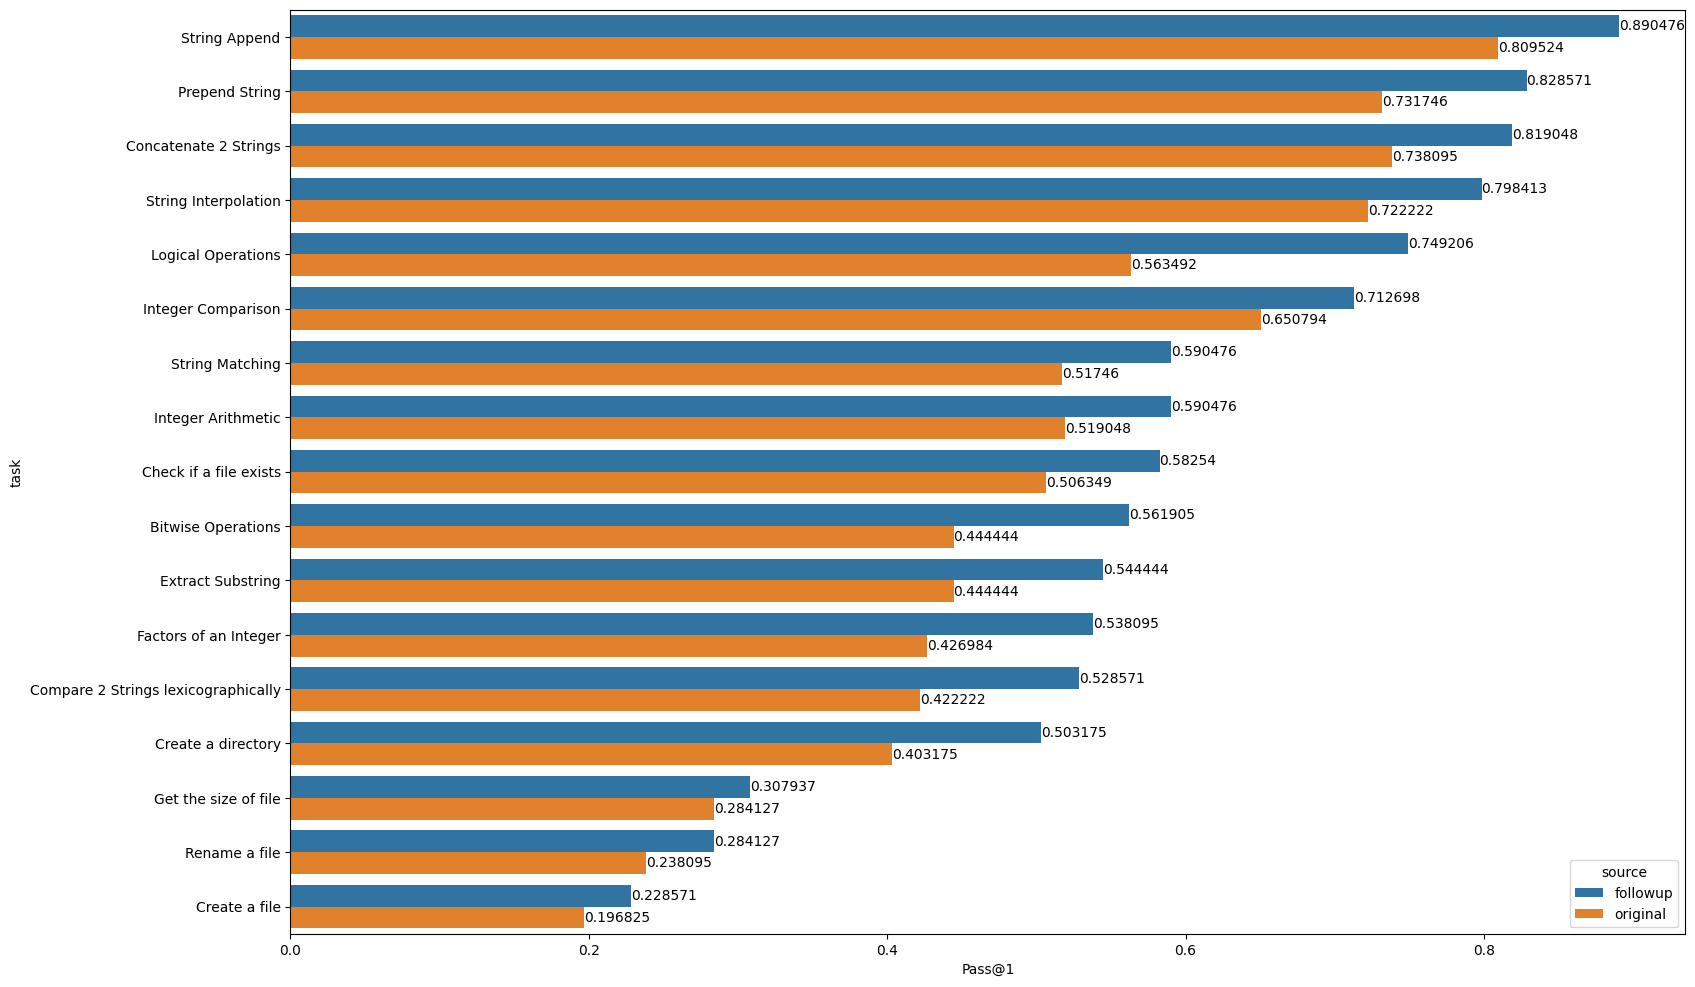

In [16]:
plot_metrics = task_metrics[["task", "Pass@1"]].copy()
plot_metrics["source"] = "original"
plot_followup_metrics = (
    task_metrics[["task", "Pass@1 Follow-up"]]
    .rename(columns={"Pass@1 Follow-up": "Pass@1"})
    .copy()
)
plot_followup_metrics["source"] = "followup"
plot_metrics = pd.concat([plot_metrics, plot_followup_metrics])
plot_metrics = plot_metrics.sort_values("Pass@1", ascending=False)
fig, ax = plt.subplots(figsize=(18, 12))
_ = sns.barplot(
    plot_metrics, y="task", x="Pass@1", hue="source", legend="brief", ax=ax
)
_ = ax.set_xlabel("Pass@1")
_ = ax.bar_label(ax.containers[0], fontsize=10)
_ = ax.bar_label(ax.containers[1], fontsize=10)

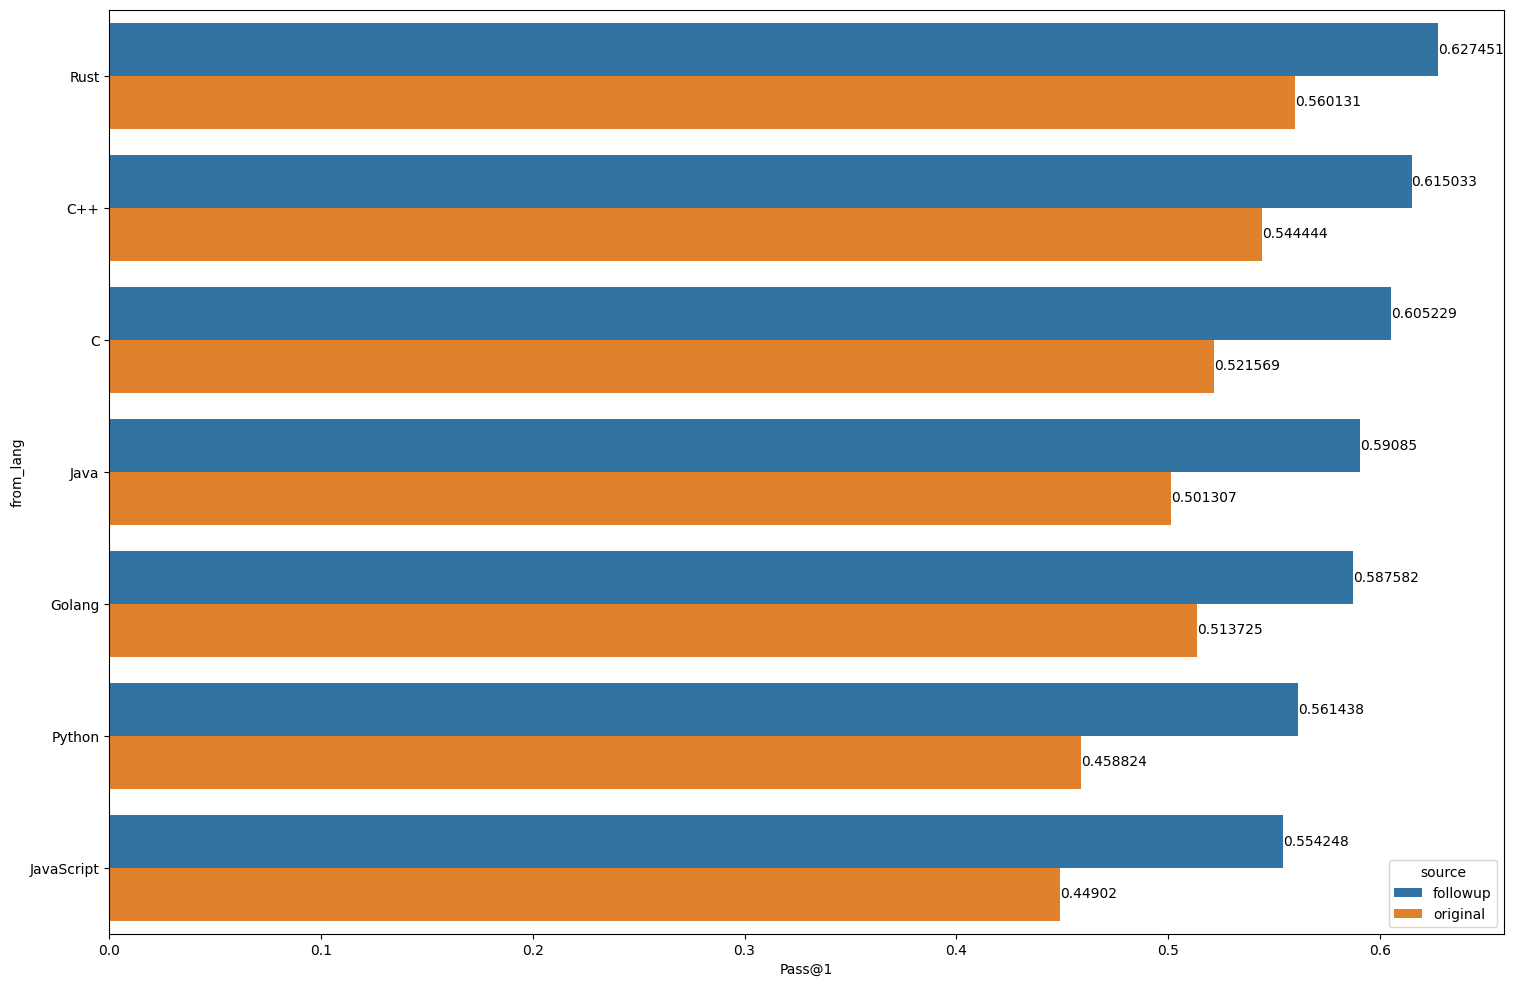

In [17]:
plot_metrics = from_lang_metrics[["from_lang", "Pass@1"]].copy()
plot_metrics["source"] = "original"
plot_followup_metrics = (
    from_lang_metrics[["from_lang", "Pass@1 Follow-up"]]
    .rename(columns={"Pass@1 Follow-up": "Pass@1"})
    .copy()
)
plot_followup_metrics["source"] = "followup"
plot_metrics = pd.concat([plot_metrics, plot_followup_metrics])
plot_metrics = plot_metrics.sort_values("Pass@1", ascending=False)
fig, ax = plt.subplots(figsize=(18, 12))
_ = sns.barplot(
    plot_metrics, y="from_lang", x="Pass@1", hue="source", legend="brief", ax=ax
)
_ = ax.set_xlabel("Pass@1")
_ = ax.bar_label(ax.containers[0], fontsize=10)
_ = ax.bar_label(ax.containers[1], fontsize=10)

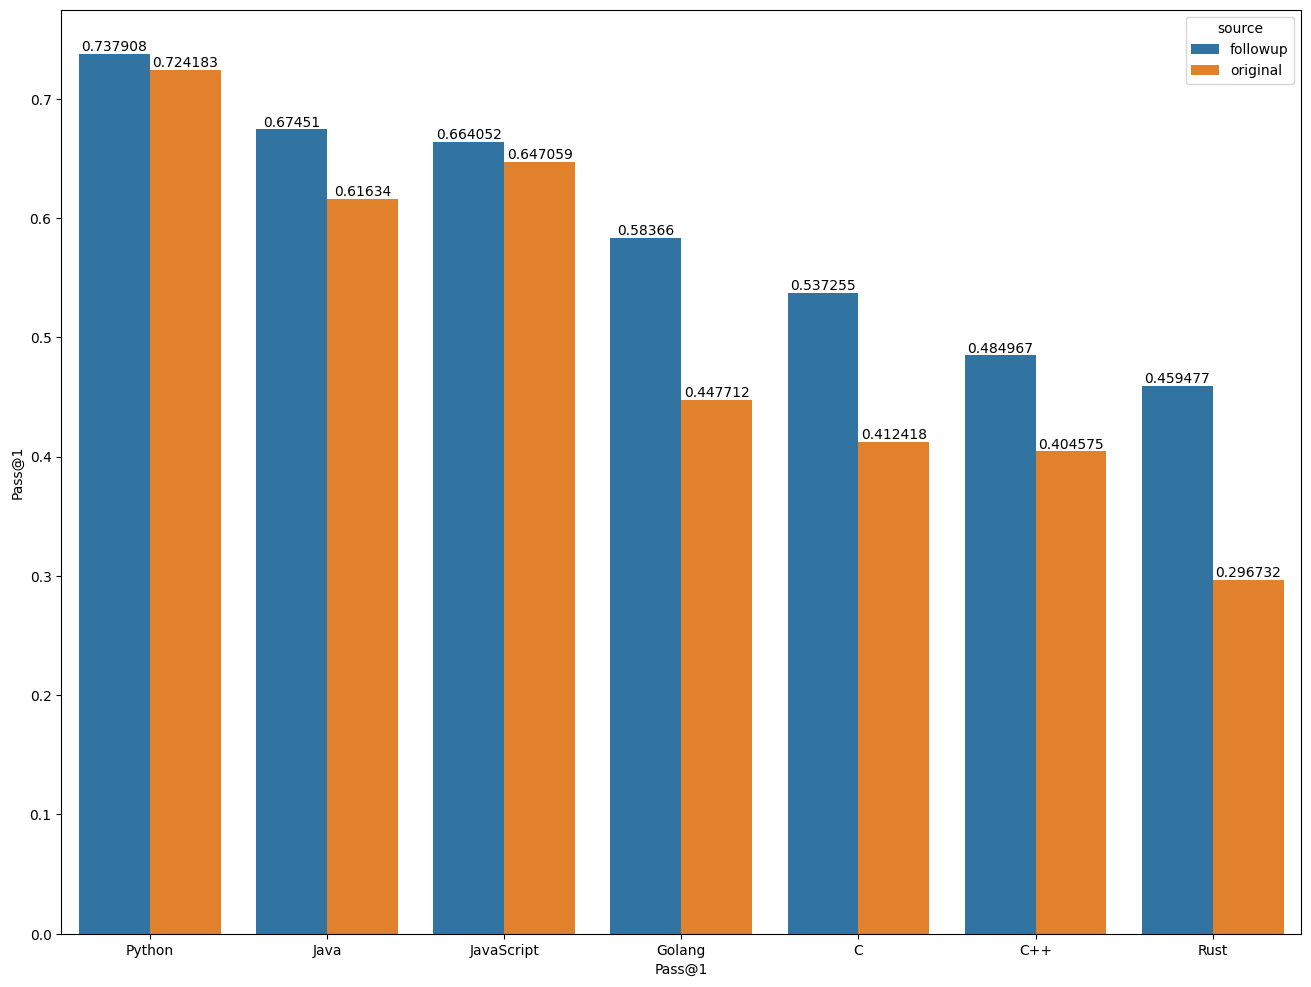

In [18]:
plot_metrics = to_lang_metrics[["to_lang", "Pass@1"]].copy()
plot_metrics["source"] = "original"
plot_followup_metrics = (
    to_lang_metrics[["to_lang", "Pass@1 Follow-up"]]
    .rename(columns={"Pass@1 Follow-up": "Pass@1"})
    .copy()
)
plot_followup_metrics["source"] = "followup"
plot_metrics = pd.concat([plot_metrics, plot_followup_metrics])
plot_metrics = plot_metrics.sort_values("Pass@1", ascending=False)
fig, ax = plt.subplots(figsize=(16, 12))
_ = sns.barplot(
    plot_metrics, x="to_lang", y="Pass@1", hue="source", legend="brief", ax=ax
)
_ = ax.set_xlabel("Pass@1")
_ = ax.bar_label(ax.containers[0], fontsize=10)
_ = ax.bar_label(ax.containers[1], fontsize=10)